# Ensembles
Lecture recap
1. Combine many weak algorithms into one strong
2. State-of-the art algorithms are ensembles
3. Most of them use decision trees as base estimators - they are fast, invariant to scaling, and handle well features of different nature

## RandomForest
1. Uses random subspace method on Decision Trees
2. Isn't prone to overfitting - but will on a small dataset
3. Easily parallelized

## Boosting
1. Ensemble members are trained consequently to compensate for imperfection
2. Will overfit, especially if strong base algorithms are used
3. Can be parallelized (Google is your friend)

## Bagging over KNN over COMET data

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
# Please note that ensembles usually need several times more time to run than
# simple algorithms. For the demonstration purposes we'll limit ourselves 
# with a subset of the hits. I ecourage you to use a subset for expolaration, then 
# train the final model on the whole dataset. Also please note that some estimator parameters
# like n_neighbours need to be scaled with the dataset.
# We'll take 200 events.
hits_train = pd.read_csv("~/data/train.csv", nrows=896400)
candidates = hits_train.loc[(hits_train.energy_deposit > 0)]
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import scale
transformed_energy = np.log(candidates.energy_deposit)**2
transformed_time = candidates.relative_time**2
comet_features = scale(np.concatenate(
        (transformed_energy[:, np.newaxis], transformed_time[:, np.newaxis]), axis=1))
comet_labels = (candidates.label == 1).values
# Baseline score from the previous seminar
from sklearn.neighbors import KNeighborsClassifier
# Please take note at n_jobs. With a small subset we can use the two available CPUs, but
# you might run out of memory when trying on the whole thing.
knn_cv = cross_val_score(KNeighborsClassifier(), comet_features, comet_labels, n_jobs=2, scoring='roc_auc')
print knn_cv.mean(), knn_cv.std()

0.952108570458 0.00476925380617


In [5]:
# And if we apply bagging
from sklearn.ensemble import BaggingClassifier
bagging_cv = cross_val_score(BaggingClassifier(base_estimator=KNeighborsClassifier(), n_jobs=2),
                             comet_features, comet_labels, scoring='roc_auc')
print bagging_cv.mean(), bagging_cv.std()

0.962790598003 0.00433126047766


Let's see how decision surface for ReandomForest changes with incerase in the number of estimators.

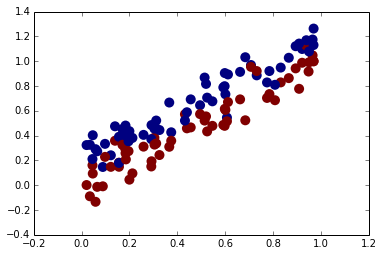

In [6]:
np.random.seed(42)
x_space = np.random.uniform(0, 1, size=60)
y0 = x_space + 0.2 + np.random.normal(size=len(x_space), scale=0.1)
y1 = x_space + np.random.normal(size=len(x_space), scale=0.1)
shuffle = np.random.permutation(2*len(x_space))
line_features = np.concatenate((np.concatenate((x_space, x_space))[:, np.newaxis],
                          np.concatenate((y0, y1))[:, np.newaxis]), axis=1)[shuffle]
line_labels = np.concatenate((np.zeros(len(y0)), np.ones(len(y1))))[shuffle]
fig, ax = plt.subplots()
ax.scatter(line_features[:, 0], line_features[:, 1], c=line_labels, edgecolors='none', s=100)

In [7]:
n_classes = 2
plot_colors = "bry"
plot_step = 0.02
from sklearn.preprocessing import scale
def plot_decision_on_axes(clf, ax, features, labels):
    X = scale(features)
    X = features
    clf.fit(X, labels)
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(labels == i)
        ax.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)

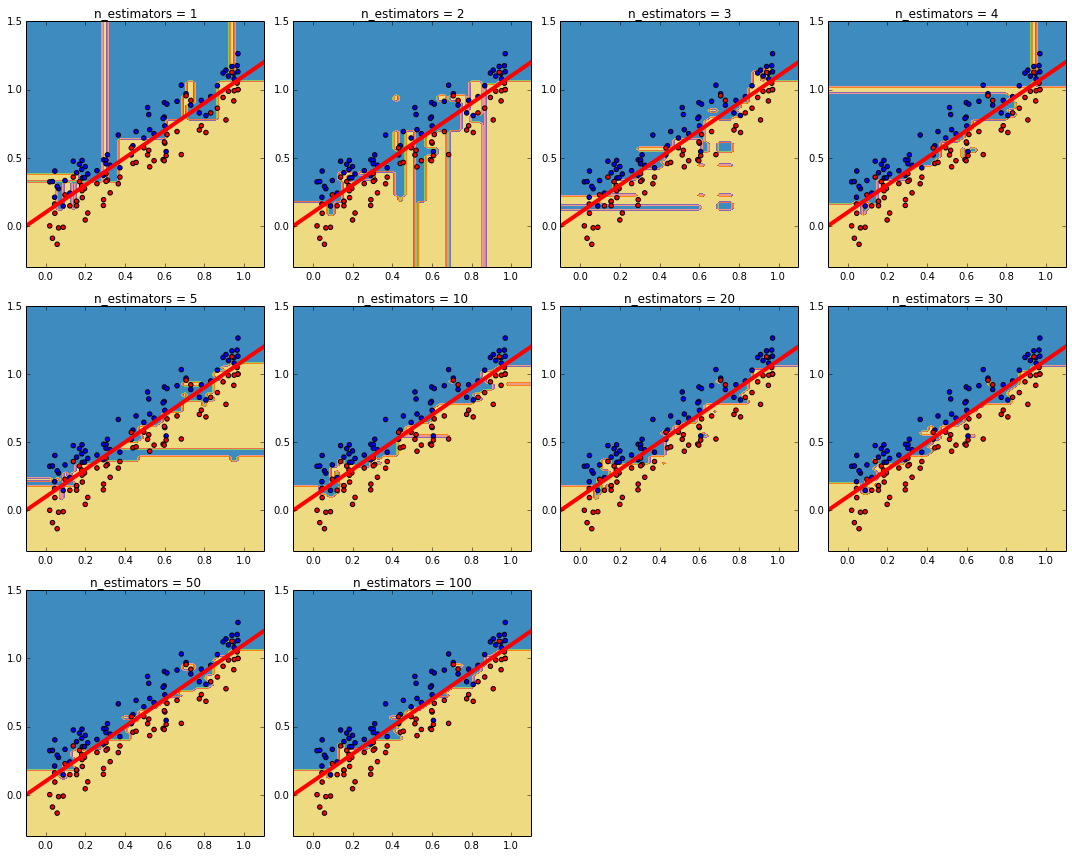

In [8]:
from sklearn.ensemble import RandomForestClassifier
estimators_set = (1, 2, 3, 4, 5, 10, 20, 30, 50, 100)
screen_width, plot_height = 15, 4
n_rows = 3
n_cols = np.ceil(np.true_divide(len(estimators_set), n_rows))
fig = plt.figure(figsize=(screen_width, plot_height*n_rows))
x_range = np.linspace(-0.1, 1.1, num=100)
y_true = x_range + 0.1
for i, n_estimators in enumerate(estimators_set):
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    plot_decision_on_axes(clf, ax, line_features, line_labels)
    ax.set_title("n_estimators = %d" % n_estimators)
    ax.plot(x_range, y_true, 'r', lw=4)
    ax.set_xlim((-0.1, 1.1))
    ax.set_ylim((-0.3, 1.5))
plt.tight_layout()

Takeaway: in most cases you can improve any classifier with bagging.

## Boosting for COMET data

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
boosting_cv = cross_val_score(GradientBoostingClassifier(), comet_features, comet_labels,
                              scoring='roc_auc', n_jobs=2)
print("Estimator GradientBoostingClassifier, cv = %g \pm %g" % (boosting_cv.mean(), boosting_cv.std()))

Estimator GradientBoostingClassifier, cv = 0.975507 \pm 0.00223328


Good. What if we try to boost RandomForest?

In [10]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_cv = cross_val_score(rf_clf, comet_features, comet_labels, scoring='roc_auc', n_jobs=2)
print("Estimator RandomForestClassifier, cv = %g \pm %g" % (rf_cv.mean(), rf_cv.std()))

Estimator RandomForestClassifier, cv = 0.957494 \pm 0.00576542


**This might take a while. Make sure you are ready to wait some 5 minutes.**

In [7]:
ada_rf_cv = cross_val_score(AdaBoostClassifier(base_estimator=rf_clf),
                            comet_features, comet_labels, scoring='roc_auc',n_jobs=2)
print("Estimator AdaBoost(RandomForestClassifier), cv = %g \pm %g" % (ada_rf_cv.mean(), ada_rf_cv.std()))

Estimator AdaBoost(RandomForestClassifier), cv = 0.983775 \pm 0.000367808


Note: this result was obtained on the whole dataset - I didn't expect it. They say boosting strong classifiers is prone to overfitting. On the part used for this notebook, it was 0.971 - they might have a point.

SELF. Plot train vs. cross-validation score as a function of the number of estimators for a bagging and a bosting algorithms on a dataset, for example, the lines (line_features, line_labels). Bonus for errorbars. Hint: you may use http://scikit-learn.org/stable/modules/generated/sklearn.learning_curve.validation_curve.html#sklearn.learning_curve.validation_curve

SELF. Use ensembles to instantly improve your Kaggle score. I suggest RandomForest, AdaBoost, GradientBoosting from sklearn and XGBoost from REP.

Ideas from yesterday:
  1. Wire distance from center.
  
  candidates.loc[:, 'wire_rho'] = wires.loc[candidates.wire_id.values, "wire_rho"].values
  2. Some function of neighbours as a feature - see seminar 1 for KDTree
  3. https://gist.github.com/arogozhnikov/e6b158cad6353e7026ac
  4. http://www.hse.ru/data/2015/06/01/1097823680/290515_EwenG_comet_at_HSE.pdf
  5. https://indico.cern.ch/event/398008/contribution/0/attachments/1123631/1603393/090715_EwenG_student_seminar_0.pdf